In [24]:
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn import svm

In [25]:
df_matches_male_players = pd.read_csv("../data/integrations/df_male_classification.csv")
df_matches_female_players = pd.read_csv("../data/integrations/df_female_classification.csv")

Assign to players without rank, the maximum rank in the dataset

In [26]:
df_matches_male_players = df_matches_male_players[df_matches_male_players['avg_rank'].notna()].reset_index()

Use box plot to set a threshold in order to discriminite weak players and strong ones.

In [27]:
fig = px.box(df_matches_male_players['avg_rank'], y='avg_rank')
fig.show()

Assign labels using the following rules:
- above median value the player is labeled as weak
- below medin value the player is labeled as strong

In [28]:
df_matches_male_players.loc[df_matches_male_players['avg_rank'] > 569, 'label'] = 1
df_matches_male_players.loc[df_matches_male_players['avg_rank'] <= 569, 'label'] = 0
df_male_classification = df_matches_male_players[['IOC','Won_Tournaments','Number_of_Matches', 'Win_Percentage', 'label']]

In [29]:
df_male_classification

,IOC,Won_Tournaments,Number_of_Matches,Win_Percentage,label
0,GER,17.0,378.0,0.706349,0.0
1,USA,0.0,7.0,0.285714,1.0
2,GER,0.0,11.0,0.454545,1.0
3,GRE,0.0,4.0,0.250000,1.0
4,ESP,0.0,94.0,0.500000,0.0
...,...,...,...,...,...
1475,AUT,0.0,4.0,0.500000,1.0
1476,POL,0.0,2.0,0.500000,1.0
1477,FRA,0.0,2.0,0.500000,1.0
1478,ITA,0.0,4.0,0.500000,1.0


One hot encoding IOC:

In [30]:
le = preprocessing.LabelEncoder()
le.fit(df_male_classification['IOC'])
df_male_classification['IOC'] = le.transform(df_male_classification['IOC'])

/tmp/ipykernel_24294/2874089141.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
#save df_male_classification
df_male_classification.to_csv("../data/df_male_classification.csv", index=False)

Split training and test

In [32]:
X = np.array(df_male_classification.drop(columns = ['label']))
y = np.array(df_male_classification['label'])
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

## KNN

Grid search for KNN:

In [36]:
#PARAMETERS:
knn_parameters = {'n_neighbors': range(2, 30), 'p': [1, 2, 3]}

knn = KNeighborsClassifier()
knn_classifier = GridSearchCV(knn, knn_parameters, cv=10)
knn_classifier.fit(X_train, y_train)
knn_accuracy = knn_classifier.score(X_test, y_test)



KNN Accuracy: 0.8945945945945946


In [41]:
print(f"KNN Accuracy: {knn_accuracy}\nModel: {knn_classifier.best_params_}")

KNN Accuracy: 0.8945945945945946
Model: {'n_neighbors': 12, 'p': 1}


## Neural Networks

In [46]:
nn_parameters = {'hidden_layer_sizes': [(5,10),(10,20),(30,50)], 
                    'activation': ['logistic', 'relu'], 
                    'solver': ['lbfgs','adam','sgd'], 
                    'alpha': [1e-3, 1e-5, 1e-6], 
                    'momentum': [0.5, 1e-1, 5e-2],
                    'learning_rate': ['adaptive'],
                    'validation_fraction': [0.25],
                    'early_stopping': [True],
                    'max_iter': [200]}

nn = MLPClassifier()
nn_classifier = GridSearchCV(nn, nn_parameters, cv=10)
nn_classifier.fit(X_train, y_train)
nn_accuracy = nn_classifier.score(X_test, y_test)

/home/dwarez/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/dwarez/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/dwarez/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.o

In [47]:
print(f"MLP Accuracy: {nn_accuracy}\nModel: {nn_classifier.best_params_}")
# 'relu', 1e-06, (10, 20), 0.5, lbfgs

MLP Accuracy: 0.9027027027027027
Model: {'activation': 'relu', 'alpha': 1e-06, 'early_stopping': True, 'hidden_layer_sizes': (10, 20), 'learning_rate': 'adaptive', 'max_iter': 200, 'momentum': 0.5, 'solver': 'lbfgs', 'validation_fraction': 0.25}


## Decision Tree

In [51]:
#PARAMETERS
dtree_parameters = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': range(1,10,1), 'min_samples_split': range(2,8,2)}

dtree = tree.DecisionTreeClassifier()
dtree_classifier = GridSearchCV(dtree, dtree_parameters, cv=10)
dtree_classifier.fit(X_train, y_train)
dtree_accuracy = dtree_classifier.score(X_test, y_test)

In [52]:
print(f"Decision Tree Accuracy: {dtree_accuracy}\nModel: {dtree_classifier.best_params_}")

Decision Tree Accuracy: 0.8810810810810811
Model: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 2, 'splitter': 'best'}


[Text(167.4, 163.07999999999998, 'X[2] <= -0.476\nentropy = 1.0\nsamples = 1110\nvalue = [551, 559]'),
 Text(83.7, 54.360000000000014, 'entropy = 0.604\nsamples = 596\nvalue = [88, 508]'),
 Text(251.10000000000002, 54.360000000000014, 'entropy = 0.467\nsamples = 514\nvalue = [463, 51]')]

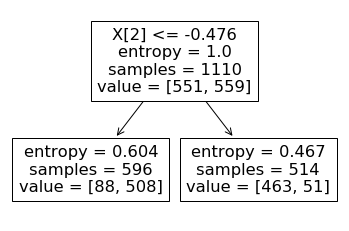

In [55]:
tree.plot_tree(dtree_classifier.best_estimator_)

## SVM

In [57]:
#PARAMETERS
svm_parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.1, 0.2, 0.3, 0.4, 0.5]}

svm = svm.SVC()
svm_classifier = GridSearchCV(svm, svm_parameters, cv=10)
svm_classifier.fit(X_train, y_train)
svm_accuracy = svm_classifier.score(X_test, y_test)

In [58]:
print(f"SVM Accuracy: {svm_accuracy}\nModel: {svm_classifier.best_params_}")

SVM Accuracy: 0.8918918918918919
Model: {'C': 0.4, 'kernel': 'linear'}
